Binomial option pricing model is a risk-neutral model used to value path-dependent options such as **American** options.

https://xplaind.com/552187/binomial-options-pricing-model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
def binom_tree_euro_value(N, T, S0, sigma, r, K, option_type='C'):
    dt = T/N
    
    # factors you expect stock price to increase and decrease by
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    
    # probability of an up move
    p = (np.exp(r * dt) - d) / (u-d)
    
    # price tree
    price_tree = np.zeros([N+1, N+1])
    
    for i in range(N+1):
        for j in range(i+1):
            price_tree[j,i] = S0 * (d**j) * (u**(i-j))
            
    # option value t = N
    option = np.zeros([N+1, N+1])
    if option_type == 'C':
        option[:, N] = np.maximum(np.zeros(N+1), price_tree[:, N]-K)
    else:
        option[:, N] = np.maximum(np.zeros(N+1), K-price_tree[:, N])
        
    # calculate option price at t=0
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option[j, i] = np.exp(-r*dt) * (p*option[j, i+1]+(1-p)*option[j+1, i+1])
            
#     print(price_tree)
    
    return option[0][0]

In [3]:
call_val = binom_tree_euro_value(50, 1, 100, 0.1, 0.05, 100, 'C')
print(f'Call value = {round(call_val, 2)}')

put_val = binom_tree_euro_value(50, 1, 100, 0.1, 0.05, 100, 'P')
print(f'Put value = {round(put_val, 2)}')

Call value = 6.78
Put value = 1.91


Text(0.5, 1.0, 'Binomial Tree - Call Values')

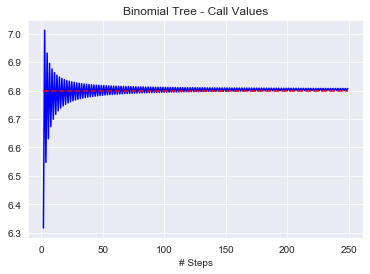

In [5]:
end = 250
call_vals = [binom_tree_euro_value(num_steps, 1, 100, 0.1, 0.05, 100) for num_steps in range(2, end)]

plt.plot(range(2,end), call_vals, color='b')
plt.plot(range(2,end), [6.8]*(end-2), color='r', linestyle='dashed')
plt.xlabel('# Steps')
plt.title('Binomial Tree - Call Values')

### American Options

Trick is need to compare strict option value at every node for generated stock price, versus option value calculated from BT moving backwards. Pick the max.

In [66]:
def binom_tree_amer_value(N, T, S0, sigma, r, K, option_type='C'):
    dt = T/N
    
    # factors you expect stock price to increase and decrease by
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    
    # probability of an UP move
    q = (np.exp(r * dt) - d) / (u-d)
    
    # price tree
    price_tree = np.zeros([N+1, N+1])
    
    
    # generate stock price tree
    # same numbers, just different syntax than above
    mu = np.arange(N + 1)
    mu = np.resize(mu, (N + 1, N + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md # only concerned w/ upper triangle --> S = np.triu(S)
        
    # valuation arrays
    if option_type == 'C':
        inner_vals = np.maximum(0, S - K) # inner value mtx
    else:
        inner_vals = np.maximum(0, K - S)
    
    vals = inner_vals.copy() # value mtx
    C = np.zeros((N+1, N+1)) # continuation vals
    ex = np.zeros((N+1, N+1)) # exercise matrix
        
    z = 0
    dr = np.exp(-r * T) # discount rate
    for i in range(N-1, -1, -1):
        # calculate option values by weighting the probability of:
        # up move (q) and down move (1-q)
        # vals[0:(N-z), i+1] --> up move b/c every row except last has up prob.
        # vals[1:(N-z+1), i+1] --> up move b/c every row except first has down prob.
        C[0:(N-z), i] = (q * vals[0:(N-z), i+1] + \
                         (1-q) * vals[1:(N-z+1), i+1]) * dr
        
        # select max of:
        # (1) calc option value
        # (2) strict option value of (S-K) from calc S value at the node
        vals[0:(N-z), i] = np.where(inner_vals[0:(N-z), i] > C[0:(N-z), i],
                                    inner_vals[0:(N-z), i],
                                    C[0:(N-z), i]
                                   )
        # same thing, just 1's and 0's for exercising American option or not
        ex[0:(N-z), i] = np.where(inner_vals[0:(N-z), i] > C[0:(N-z), i], 1, 0)
        z += 1
        
    C[:, -1] = inner_vals[:, -1]

    if option_type == 'P':
        # where ex == 1, more optimal to exercise option than wait until expiration
        # valuation at that date greater than BT calculated value
        # for call option (w/ no dividends), ex = 0 always
        print(np.triu(C))
        print(np.triu(inner_vals))
        print(ex)

    return round(vals[0][0], 2)

In [67]:
N = 3
T = 1
sigma = 0.1
r = 0.01
S0 = 100
K = 95

binom_tree_amer_value(N, T, S0, sigma, r, K, 'P')

[[ 1.50813017  0.14095313  0.          0.        ]
 [ 0.          2.98801436  0.29322533  0.        ]
 [ 0.          0.          5.55199832  0.60999776]
 [ 0.          0.          0.         10.90348686]]
[[ 0.          0.          0.          0.        ]
 [ 0.          0.60999776  0.          0.        ]
 [ 0.          0.          5.90527477  0.60999776]
 [ 0.          0.          0.         10.90348686]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


1.51